In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Full imports
import torch
from blockgen.configs import VoxelConfig, DiffusionConfig
from blockgen.utils import create_model_and_trainer, create_dataloaders
from blockgen.inference import DiffusionInference3D
from scripts.generate import load_model_for_inference

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


In [8]:
# Configs
voxel_config = VoxelConfig(
    use_rgb=True,
    default_color=[0.5, 0.5, 0.5],
    alpha_weight=1.0,
    rgb_weight=1.0
)

diffusion_config = DiffusionConfig(
    num_timesteps=1000,
    use_ema=True,
    ema_decay=0.9999,
    ema_update_after_step=0,
    ema_device=device,
    seed=42
)

In [9]:
# Create model and trainer
trainer, model = create_model_and_trainer(
    voxel_config=voxel_config,
    diffusion_config=diffusion_config,
    resolution=32,
    device=device
)

Total parameters: 120099908


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [10]:
train_loader, test_loader = create_dataloaders(
    voxel_dir="objaverse_data_voxelized",
    annotation_file="objaverse_data/annotations.json",
    config=diffusion_config,
    config_voxel=voxel_config,
    batch_size=2
)


inding voxel files: 259776it [02:36, 1662.90it/s]


Found 259776 files (including augmentations)


In [11]:
metrics = trainer.train(
    train_loader,
    test_loader,
    total_steps=10,
    save_every=5_000,
    eval_every=10_000,
    save_dir='runs/sale no mubarak'
)

Training:   0%|                                          | 0/10 [00:00<?, ?it/s]

tensor([0.0000, 0.0039, 0.0275, 0.0392, 0.0510, 0.0706, 0.0745, 0.0941, 0.0980,
        0.1020, 0.1059, 0.1098, 0.1255, 0.1294, 0.1333, 0.1373, 0.1412, 0.1451,
        0.1490, 0.1529, 0.1569, 0.1647, 0.1686, 0.1765, 0.1804, 0.1843, 0.1882,
        0.1922, 0.1961, 0.1980, 0.2000, 0.2039, 0.2078, 0.2118, 0.2157, 0.2196,
        0.2235, 0.2275, 0.2314, 0.2353, 0.2392, 0.2431, 0.2471, 0.2510, 0.2549,
        0.2627, 0.2667, 0.2706, 0.2745, 0.2824, 0.2863, 0.2902, 0.2941, 0.2980,
        0.3020, 0.3059, 0.3137, 0.3176, 0.3216, 0.3255, 0.3294, 0.3333, 0.3373,
        0.3412, 0.3451, 0.3490, 0.3529, 0.3569, 0.3608, 0.3647, 0.3686, 0.3725,
        0.3765, 0.3843, 0.3882, 0.3922, 0.3961, 0.4000, 0.4039, 0.4078, 0.4118,
        0.4157, 0.4196, 0.4235, 0.4275, 0.4314, 0.4353, 0.4392, 0.4431, 0.4471,
        0.4510, 0.4549, 0.4588, 0.4627, 0.4667, 0.4706, 0.4745, 0.4784, 0.4863,
        0.4902, 0.4941, 0.4980, 0.5020, 0.5059, 0.5098, 0.5157, 0.5176, 0.5216,
        0.5255, 0.5294, 0.5373, 0.5412, 

Training:  10%|▌     | 1/10 [00:03<00:34,  3.84s/it, loss=242.0631, lr=0.000100]

tensor([0.0000, 0.2000, 0.9373], device='cuda:0')
tensor([0.0000, 0.1529, 0.9373], device='cuda:0')
tensor([0.0000, 0.1529, 0.9373], device='cuda:0')
tensor([0., 1.], device='cuda:0')


Training:  20%|█    | 2/10 [00:04<00:15,  1.97s/it, loss=4959.1807, lr=0.000098]

tensor([0.5000], device='cuda:0')
tensor([0.5000], device='cuda:0')
tensor([0.5000], device='cuda:0')
tensor([0., 1.], device='cuda:0')


Training:  30%|██▍     | 3/10 [00:05<00:09,  1.38s/it, loss=7.8071, lr=0.000091]

tensor([0.5000], device='cuda:0')
tensor([0.5000], device='cuda:0')
tensor([0.5000], device='cuda:0')
tensor([0., 1.], device='cuda:0')


Training:  40%|███▏    | 4/10 [00:05<00:06,  1.10s/it, loss=4.4507, lr=0.000080]

tensor([0.5000], device='cuda:0')
tensor([0.5000], device='cuda:0')
tensor([0.5000], device='cuda:0')
tensor([0., 1.], device='cuda:0')


Training:  50%|███▌   | 5/10 [00:06<00:04,  1.06it/s, loss=20.2207, lr=0.000066]

tensor([0.0000, 0.3201, 0.3216, 0.3525, 0.3657, 0.3686, 0.3951, 0.4113, 0.4157,
        0.4196, 0.4377, 0.4569, 0.4627, 0.4797, 0.4804, 0.4824, 0.4863, 0.5025,
        0.5039, 0.5098, 0.5142, 0.5172, 0.5211, 0.5230, 0.5304, 0.5338, 0.5353,
        0.5363, 0.5373, 0.5412, 0.5431, 0.5436, 0.5446, 0.5451, 0.5461, 0.5466,
        0.5471, 0.5480, 0.5490, 0.5495, 0.5510, 0.5529, 0.5549, 0.5554, 0.5569,
        0.5588, 0.5598, 0.5608, 0.5627, 0.5632, 0.5637, 0.5647, 0.5657, 0.5667,
        0.5676, 0.5686, 0.5706, 0.5708, 0.5725, 0.5735, 0.5745, 0.5750, 0.5755,
        0.5760, 0.5765, 0.5775, 0.5784, 0.5789, 0.5794, 0.5804, 0.5814, 0.5819,
        0.5824, 0.5828, 0.5833, 0.5841, 0.5843, 0.5848, 0.5853, 0.5855, 0.5858,
        0.5863, 0.5868, 0.5873, 0.5880, 0.5882, 0.5892, 0.5897, 0.5902, 0.5907,
        0.5912, 0.5919, 0.5922, 0.5926, 0.5929, 0.5931, 0.5936, 0.5941, 0.5951,
        0.5953, 0.5961, 0.5966, 0.5971, 0.5975, 0.5980, 0.5985, 0.5990, 0.5995,
        0.6000, 0.6005, 0.6010, 0.6012, 

Training:  60%|████▏  | 6/10 [00:07<00:03,  1.17it/s, loss=67.0415, lr=0.000051]

tensor([0.5000], device='cuda:0')
tensor([0.5000], device='cuda:0')
tensor([0.5000], device='cuda:0')
tensor([0., 1.], device='cuda:0')


Training:  70%|███▌ | 7/10 [00:07<00:02,  1.26it/s, loss=1192.0237, lr=0.000035]

tensor([0.5000], device='cuda:0')
tensor([0.5000], device='cuda:0')
tensor([0.5000], device='cuda:0')
tensor([0., 1.], device='cuda:0')


Training:  80%|████▊ | 8/10 [00:08<00:01,  1.32it/s, loss=149.4168, lr=0.000021]

tensor([0.0000, 0.0706, 0.0980, 0.1000, 0.1020, 0.1059, 0.1098, 0.1157, 0.1167,
        0.1176, 0.1216, 0.1235, 0.1245, 0.1294, 0.1333, 0.1353, 0.1373, 0.1392,
        0.1412, 0.1431, 0.1451, 0.1471, 0.1490, 0.1529, 0.1569, 0.1608, 0.1647,
        0.1657, 0.1667, 0.1686, 0.1706, 0.1725, 0.1745, 0.1804, 0.1824, 0.1843,
        0.1882, 0.1922, 0.1956, 0.1961, 0.1980, 0.2000, 0.2039, 0.2078, 0.2118,
        0.2157, 0.2196, 0.2235, 0.2275, 0.2314, 0.2333, 0.2353, 0.2392, 0.2431,
        0.2451, 0.2471, 0.2510, 0.2549, 0.2588, 0.2627, 0.2667, 0.2706, 0.2745,
        0.2784, 0.2804, 0.2824, 0.2863, 0.2941, 0.2980, 0.3020, 0.3059, 0.3098,
        0.3137, 0.3176, 0.3216, 0.3255, 0.3275, 0.3294, 0.3314, 0.3333, 0.3373,
        0.3412, 0.3451, 0.3471, 0.3490, 0.3529, 0.3569, 0.3608, 0.3647, 0.3686,
        0.3725, 0.3765, 0.3804, 0.3843, 0.3882, 0.3922, 0.3941, 0.3961, 0.4000,
        0.4039, 0.4078, 0.4118, 0.4157, 0.4196, 0.4235, 0.4275, 0.4314, 0.4353,
        0.4392, 0.4431, 0.4471, 0.4510, 

Training:  90%|██████▎| 9/10 [00:09<00:00,  1.36it/s, loss=13.7234, lr=0.000010]

tensor([0.0000, 0.0078, 0.0157, 0.0196, 0.0471, 0.0588, 0.0667, 0.0706, 0.0745,
        0.0863, 0.0902, 0.0941, 0.0980, 0.1020, 0.1098, 0.1137, 0.1216, 0.1333,
        0.1373, 0.1412, 0.1451, 0.1490, 0.1529, 0.1569, 0.1608, 0.1647, 0.1686,
        0.1725, 0.1765, 0.1804, 0.1843, 0.1922, 0.1961, 0.2000, 0.2039, 0.2078,
        0.2118, 0.2157, 0.2196, 0.2235, 0.2275, 0.2314, 0.2353, 0.2392, 0.2431,
        0.2471, 0.2510, 0.2549, 0.2588, 0.2627, 0.2706, 0.2745, 0.2784, 0.2824,
        0.2863, 0.2941, 0.2980, 0.3020, 0.3059, 0.3098, 0.3137, 0.3176, 0.3255,
        0.3333, 0.3373, 0.3412, 0.3451, 0.3490, 0.3529, 0.3569, 0.3608, 0.3647,
        0.3686, 0.3725, 0.3804, 0.3843, 0.3882, 0.3922, 0.4000, 0.4039, 0.4157,
        0.4196, 0.4235, 0.4275, 0.4314, 0.4353, 0.4392, 0.4471, 0.4549, 0.4667,
        0.4706, 0.4745, 0.4784, 0.4863, 0.4902, 0.4941, 0.4980, 0.5020, 0.5059,
        0.5098, 0.5176, 0.5216, 0.5255, 0.5333, 0.5373, 0.5412, 0.5451, 0.5490,
        0.5529, 0.5569, 0.5608, 0.5686, 


raining: 100%|██████| 10/10 [00:09<00:00,  1.01it/s, loss=10.1599, lr=0.000003]

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['training_losses'])
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(metrics['test_steps'], metrics['test_losses'])
plt.title('Test Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [3]:
import sys
import torch
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
#!pip install iopath
#!pip install --no-deps --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
print(f"pip install --no-deps --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html")

pip install --no-deps --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu117_pyt201/download.html


In [107]:
model = load_model_for_inference('runs/experiment_color/models/model_step_30000', voxel_config=voxel_config, diffusion_config=diffusion_config, device=device, ema=False)

Loaded main model weights


In [113]:
# Inference
inferencer = DiffusionInference3D(
    model=model,
    noise_scheduler=model.noise_scheduler,
    config=voxel_config,
    device=device
)

tensor([999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987, 986,
        985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974, 973, 972,
        971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958,
        957, 956, 955, 954, 953, 952, 951, 950, 949, 948, 947, 946, 945, 944,
        943, 942, 941, 940, 939, 938, 937, 936, 935, 934, 933, 932, 931, 930,
        929, 928, 927, 926, 925, 924, 923, 922, 921, 920, 919, 918, 917, 916,
        915, 914, 913, 912, 911, 910, 909, 908, 907, 906, 905, 904, 903, 902,
        901, 900, 899, 898, 897, 896, 895, 894, 893, 892, 891, 890, 889, 888,
        887, 886, 885, 884, 883, 882, 881, 880, 879, 878, 877, 876, 875, 874,
        873, 872, 871, 870, 869, 868, 867, 866, 865, 864, 863, 862, 861, 860,
        859, 858, 857, 856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846,
        845, 844, 843, 842, 841, 840, 839, 838, 837, 836, 835, 834, 833, 832,
        831, 830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 8

Sampling Steps:   0%|                                   | 0/700 [00:00<?, ?it/s]

699 0.08346322178840637 0.9965108633041382
timestep: 699

Sample 0 distribution:
Histogram bins: [0.1860113  0.24504033 0.30406937 0.36309838 0.42212743 0.48115647
 0.5401855  0.59921455 0.65824354 0.7172726  0.7763016 ]
Histogram counts: [    3     8    57   765  5491 13944 10052  2215   219    14]
Percentiles: 10%: 0.460, 50%: 0.525, 90%: 0.591
RG range: [0.000, 1.000]
Alpha range: [0.186, 0.776]
Number of vertices: 262120
Max face index: 262119
Number of faces: 393180


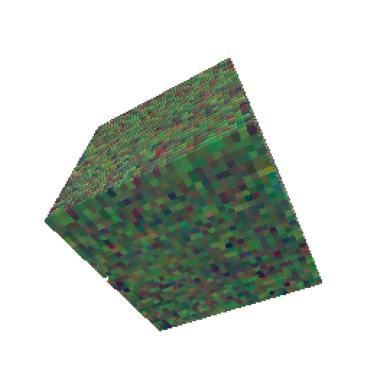

Sampling Steps:   0%|                           | 3/700 [00:04<12:34,  1.08s/it]

698 0.08405470103025436 0.9964611530303955
697 0.08464951068162918 0.9964107871055603


Sampling Steps:   1%|▏                          | 5/700 [00:04<05:49,  1.99it/s]

696 0.08524766564369202 0.9963597655296326
695 0.08584918826818466 0.9963081479072571


Sampling Steps:   1%|▎                          | 7/700 [00:05<03:27,  3.34it/s]

694 0.08645407110452652 0.9962558150291443
693 0.08706234395503998 0.9962028861045837


Sampling Steps:   1%|▎                          | 9/700 [00:05<02:27,  4.69it/s]

692 0.08767400681972504 0.9961492419242859
691 0.08828908205032349 0.9960948824882507


Sampling Steps:   2%|▍                         | 11/700 [00:05<01:59,  5.76it/s]

690 0.08890756964683533 0.996039867401123
689 0.08952948451042175 0.9959841966629028


Sampling Steps:   2%|▍                         | 13/700 [00:05<01:46,  6.45it/s]

688 0.09015484154224396 0.9959277510643005
687 0.09078364819288254 0.9958706498146057


Sampling Steps:   2%|▌                         | 15/700 [00:06<01:40,  6.80it/s]

686 0.09141591936349869 0.9958127737045288
685 0.092051662504673 0.9957542419433594


Sampling Steps:   2%|▋                         | 17/700 [00:06<01:37,  7.03it/s]

684 0.09269088506698608 0.9956949353218079
683 0.09333361685276031 0.995634913444519


Sampling Steps:   3%|▋                         | 19/700 [00:06<01:34,  7.17it/s]

682 0.0939798504114151 0.9955741167068481
681 0.09462960064411163 0.9955125451087952


Sampling Steps:   3%|▊                         | 21/700 [00:07<01:33,  7.24it/s]

680 0.09528288245201111 0.9954502582550049
679 0.09593970328569412 0.9953871369361877


Sampling Steps:   3%|▊                         | 23/700 [00:07<01:33,  7.27it/s]

678 0.09660007804632187 0.9953233003616333
677 0.09726401418447495 0.995258629322052


Sampling Steps:   4%|▉                         | 25/700 [00:07<01:32,  7.28it/s]

676 0.09793153405189514 0.9951931834220886
675 0.09860263019800186 0.9951269030570984


Sampling Steps:   4%|█                         | 27/700 [00:07<01:32,  7.29it/s]

674 0.0992773249745369 0.9950597882270813
673 0.09995563328266144 0.9949918985366821


Sampling Steps:   4%|█                         | 29/700 [00:08<01:31,  7.31it/s]

672 0.10063754767179489 0.9949231743812561
671 0.10132310539484024 0.9948535561561584


Sampling Steps:   4%|█▏                        | 31/700 [00:08<01:31,  7.30it/s]

670 0.10201229155063629 0.9947831630706787
669 0.10270512849092484 0.9947118163108826


Sampling Steps:   5%|█▏                        | 33/700 [00:08<01:31,  7.30it/s]

668 0.10340163111686707 0.9946396946907043
667 0.10410181432962418 0.9945666193962097


Sampling Steps:   5%|█▎                        | 35/700 [00:09<01:31,  7.29it/s]

666 0.10480567067861557 0.9944927096366882
665 0.10551322251558304 0.9944179058074951


Sampling Steps:   5%|█▎                        | 37/700 [00:09<01:31,  7.29it/s]

664 0.10622447729110718 0.9943421483039856
663 0.10693944990634918 0.9942655563354492


Sampling Steps:   6%|█▍                        | 39/700 [00:09<01:30,  7.27it/s]

662 0.10765814036130905 0.9941879510879517
661 0.10838057845830917 0.9941094517707825


Sampling Steps:   6%|█▌                        | 41/700 [00:09<01:30,  7.29it/s]

660 0.10910675674676895 0.9940300583839417
659 0.10983669012784958 0.9939496517181396


Sampling Steps:   6%|█▌                        | 43/700 [00:10<01:30,  7.27it/s]

658 0.11057040095329285 0.9938682913780212
657 0.11130788177251816 0.9937859773635864


Sampling Steps:   6%|█▋                        | 45/700 [00:10<01:30,  7.27it/s]

656 0.1120491549372673 0.9937026500701904
655 0.11279422044754028 0.993618369102478


Sampling Steps:   7%|█▋                        | 47/700 [00:10<01:29,  7.28it/s]

654 0.11354309320449829 0.9935330748558044
653 0.11429578810930252 0.9934467673301697


Sampling Steps:   7%|█▊                        | 49/700 [00:10<01:30,  7.23it/s]

652 0.11505231261253357 0.9933594465255737
651 0.11581267416477203 0.9932710528373718


Sampling Steps:   7%|█▊                        | 50/700 [00:11<01:29,  7.25it/s]

650 0.11657688766717911 0.9931817054748535
649 0.11734495311975479 0.9930912256240845
timestep: 649

Sample 0 distribution:
Histogram bins: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Histogram counts: [14308   580   583   548   583   536   580   556   537 13957]
Percentiles: 10%: 0.000, 50%: 0.460, 90%: 1.000
RG range: [0.000, 1.000]
Alpha range: [0.000, 1.000]
Number of vertices: 140768
Max face index: 140767
Number of faces: 211152


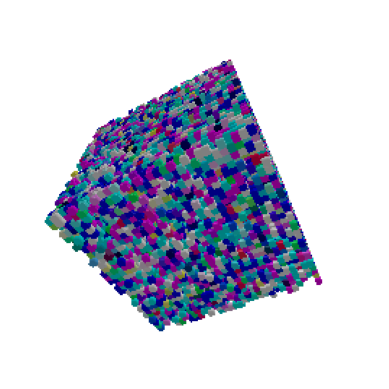

Sampling Steps:   8%|█▉                        | 53/700 [00:13<05:17,  2.04it/s]

648 0.11811689287424088 0.9929996728897095
647 0.11889270693063736 0.9929071068763733


Sampling Steps:   8%|██                        | 55/700 [00:14<03:20,  3.22it/s]

646 0.11967241019010544 0.9928134083747864
645 0.12045601010322571 0.9927186369895935


Sampling Steps:   8%|██                        | 57/700 [00:14<02:22,  4.50it/s]

644 0.12124352157115936 0.9926227927207947
643 0.1220349445939064 0.9925258159637451


Sampling Steps:   8%|██▏                       | 59/700 [00:14<01:54,  5.59it/s]

642 0.12283030152320862 0.9924276471138
641 0.12362959235906601 0.992328405380249


Sampling Steps:   9%|██▎                       | 61/700 [00:14<01:40,  6.35it/s]

640 0.12443282455205917 0.9922280311584473
639 0.1252400130033493 0.99212646484375


Sampling Steps:   9%|██▎                       | 63/700 [00:15<01:33,  6.78it/s]

638 0.1260511577129364 0.992023766040802
637 0.12686629593372345 0.9919198155403137


Sampling Steps:   9%|██▍                       | 65/700 [00:15<01:30,  7.04it/s]

636 0.12768541276454926 0.9918147325515747
635 0.12850850820541382 0.9917083978652954


Sampling Steps:  10%|██▍                       | 67/700 [00:15<01:28,  7.19it/s]

634 0.12933561205863953 0.9916008710861206
633 0.13016672432422638 0.9914920926094055


Sampling Steps:  10%|██▌                       | 69/700 [00:16<01:27,  7.25it/s]

632 0.13100185990333557 0.9913821220397949
631 0.1318410187959671 0.991270899772644


Sampling Steps:  10%|██▋                       | 71/700 [00:16<01:26,  7.26it/s]

630 0.13268421590328217 0.9911583662033081
629 0.13353146612644196 0.9910445809364319


Sampling Steps:  10%|██▋                       | 73/700 [00:16<01:26,  7.26it/s]

628 0.13438275456428528 0.9909294843673706
627 0.13523812592029572 0.990813136100769


Sampling Steps:  11%|██▊                       | 75/700 [00:16<01:26,  7.22it/s]

626 0.13609756529331207 0.9906954169273376
625 0.13696107268333435 0.990576446056366


Sampling Steps:  11%|██▊                       | 77/700 [00:17<01:27,  7.11it/s]

624 0.13782867789268494 0.9904561042785645
623 0.13870038092136383 0.9903343915939331


Sampling Steps:  11%|██▉                       | 79/700 [00:17<01:26,  7.18it/s]

622 0.13957618176937103 0.9902113080024719
621 0.14045609533786774 0.9900869131088257


Sampling Steps:  12%|███                       | 81/700 [00:17<01:25,  7.24it/s]

620 0.14134013652801514 0.9899610877037048
619 0.14222830533981323 0.9898338913917542


Sampling Steps:  12%|███                       | 83/700 [00:17<01:24,  7.27it/s]

618 0.14312060177326202 0.9897052645683289
617 0.1440170705318451 0.989575207233429


Sampling Steps:  12%|███▏                      | 85/700 [00:18<01:24,  7.28it/s]

616 0.14491766691207886 0.9894437193870544
615 0.1458224356174469 0.9893108010292053


Sampling Steps:  12%|███▏                      | 87/700 [00:18<01:24,  7.26it/s]

614 0.14673137664794922 0.9891763925552368
613 0.14764449000358582 0.9890404939651489


Sampling Steps:  13%|███▎                      | 89/700 [00:18<01:24,  7.27it/s]

612 0.14856179058551788 0.9889031648635864
611 0.14948327839374542 0.9887642860412598


Sampling Steps:  13%|███▍                      | 91/700 [00:19<01:23,  7.26it/s]

610 0.15040895342826843 0.988623857498169
609 0.1513388603925705 0.9884819388389587


Sampling Steps:  13%|███▍                      | 93/700 [00:19<01:23,  7.26it/s]

608 0.15227295458316803 0.9883384704589844
607 0.1532112956047058 0.9881934523582458


Sampling Steps:  14%|███▌                      | 95/700 [00:19<01:23,  7.26it/s]

606 0.15415385365486145 0.9880468249320984
605 0.15510064363479614 0.9878987073898315


Sampling Steps:  14%|███▌                      | 97/700 [00:19<01:22,  7.28it/s]

604 0.1560516655445099 0.9877488613128662
603 0.15700694918632507 0.9875975251197815


Sampling Steps:  14%|███▋                      | 99/700 [00:20<01:22,  7.28it/s]

602 0.1579664945602417 0.9874444603919983
601 0.15893028676509857 0.9872897863388062


Sampling Steps:  14%|███▌                     | 100/700 [00:20<01:22,  7.28it/s]

600 0.15989835560321808 0.9871335029602051
599 0.16087070107460022 0.9869754910469055
timestep: 599

Sample 0 distribution:
Histogram bins: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Histogram counts: [13889   633   708   707   675   694   697   652   616 13497]
Percentiles: 10%: 0.000, 50%: 0.463, 90%: 1.000
RG range: [0.000, 1.000]
Alpha range: [0.000, 1.000]
Number of vertices: 143088
Max face index: 143087
Number of faces: 214632


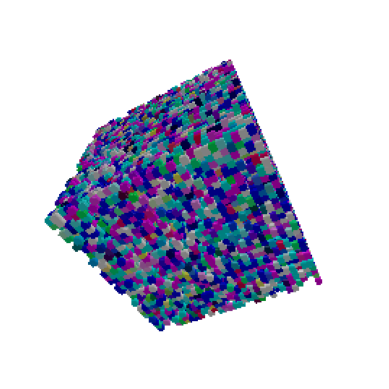

Sampling Steps:  15%|███▋                     | 103/700 [00:23<04:48,  2.07it/s]

598 0.161847323179245 0.9868158102035522
597 0.1628282368183136 0.9866544008255005


Sampling Steps:  15%|███▊                     | 105/700 [00:23<03:02,  3.26it/s]

596 0.16381344199180603 0.986491322517395
595 0.1648029386997223 0.9863265156745911


Sampling Steps:  15%|███▊                     | 107/700 [00:23<02:10,  4.54it/s]

594 0.16579674184322357 0.9861599206924438
593 0.16679486632347107 0.9859915971755981


Sampling Steps:  16%|███▉                     | 109/700 [00:23<01:45,  5.62it/s]

592 0.16779731214046478 0.985821545124054
591 0.16880406439304352 0.9856496453285217


Sampling Steps:  16%|███▉                     | 111/700 [00:24<01:32,  6.37it/s]

590 0.16981515288352966 0.9854758977890015
589 0.17083057761192322 0.9853004217147827


Sampling Steps:  16%|████                     | 113/700 [00:24<01:26,  6.79it/s]

588 0.17185033857822418 0.9851230382919312
587 0.17287445068359375 0.9849438667297363


Sampling Steps:  16%|████                     | 115/700 [00:24<01:23,  7.02it/s]

586 0.17390291392803192 0.9847627878189087
585 0.1749357283115387 0.984579861164093


Sampling Steps:  17%|████▏                    | 117/700 [00:25<01:21,  7.15it/s]

584 0.17597290873527527 0.9843950271606445
583 0.17701444029808044 0.9842082858085632


Sampling Steps:  17%|████▎                    | 119/700 [00:25<01:20,  7.22it/s]

582 0.1780603528022766 0.9840195775032043
581 0.17911063134670258 0.9838289022445679


Sampling Steps:  17%|████▎                    | 121/700 [00:25<01:19,  7.25it/s]

580 0.18016529083251953 0.9836363196372986
579 0.18122434616088867 0.9834417700767517


Sampling Steps:  18%|████▍                    | 123/700 [00:25<01:19,  7.25it/s]

578 0.1822877824306488 0.9832452535629272
577 0.18335561454296112 0.9830466508865356


Sampling Steps:  18%|████▍                    | 125/700 [00:26<01:19,  7.27it/s]

576 0.18442784249782562 0.9828460812568665
575 0.1855044662952423 0.9826434254646301


Sampling Steps:  18%|████▌                    | 127/700 [00:26<01:18,  7.28it/s]

574 0.18658550083637238 0.9824387431144714
573 0.18767093122005463 0.9822319746017456


Sampling Steps:  18%|████▌                    | 129/700 [00:26<01:18,  7.28it/s]

572 0.18876078724861145 0.9820231199264526
571 0.18985506892204285 0.9818121194839478


Sampling Steps:  19%|████▋                    | 131/700 [00:26<01:18,  7.29it/s]

570 0.19095374643802643 0.9815990328788757
569 0.19205686450004578 0.9813838005065918


Sampling Steps:  19%|████▊                    | 133/700 [00:27<01:17,  7.30it/s]

568 0.1931643933057785 0.981166422367096
567 0.194276362657547 0.9809468388557434


Sampling Steps:  19%|████▊                    | 134/700 [00:27<01:17,  7.29it/s]

566 0.19539277255535126 0.9807250499725342


Sampling Steps:  19%|████▊                    | 136/700 [00:27<01:25,  6.59it/s]

565 0.1965136080980301 0.980501115322113
564 0.1976388692855835 0.9802749156951904


Sampling Steps:  20%|████▉                    | 138/700 [00:27<01:21,  6.90it/s]

563 0.19876858592033386 0.9800464510917664
562 0.1999027580022812 0.9798157215118408


Sampling Steps:  20%|█████                    | 140/700 [00:28<01:18,  7.09it/s]

561 0.20104137063026428 0.9795827865600586
560 0.20218440890312195 0.9793474674224854


Sampling Steps:  20%|█████                    | 142/700 [00:28<01:17,  7.19it/s]

559 0.20333191752433777 0.9791098833084106
558 0.20448386669158936 0.9788699150085449


Sampling Steps:  21%|█████▏                   | 144/700 [00:28<01:16,  7.25it/s]

557 0.2056402862071991 0.978627622127533
556 0.2068011611700058 0.9783830046653748


Sampling Steps:  21%|█████▏                   | 146/700 [00:29<01:16,  7.27it/s]

555 0.20796647667884827 0.9781359434127808
554 0.2091362625360489 0.9778864979743958


Sampling Steps:  21%|█████▎                   | 148/700 [00:29<01:15,  7.29it/s]

553 0.21031051874160767 0.977634608745575
552 0.2114892303943634 0.9773803353309631


Sampling Steps:  21%|█████▎                   | 150/700 [00:29<01:15,  7.31it/s]

551 0.2126724123954773 0.9771235585212708
550 0.21386004984378815 0.9768642783164978
549 0.21505215764045715 0.9766025543212891
timestep: 549

Sample 0 distribution:
Histogram bins: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Histogram counts: [12222   473   798  1433  1697  1684  1355   762   435 11909]
Percentiles: 10%: 0.000, 50%: 0.486, 90%: 1.000
RG range: [0.000, 1.000]
Alpha range: [0.000, 1.000]
Number of vertices: 157864
Max face index: 157863
Number of faces: 236796


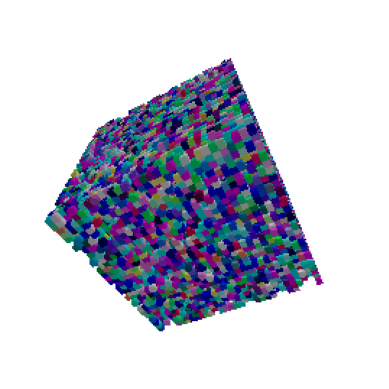

Sampling Steps:  22%|█████▍                   | 153/700 [00:32<04:34,  1.99it/s]

548 0.21624873578548431 0.976338267326355
547 0.21744978427886963 0.9760714769363403


Sampling Steps:  22%|█████▌                   | 155/700 [00:32<02:52,  3.16it/s]

546 0.2186552882194519 0.9758021831512451
545 0.21986526250839233 0.9755302667617798


Sampling Steps:  22%|█████▌                   | 157/700 [00:33<02:02,  4.44it/s]

544 0.2210797220468521 0.9752557277679443
543 0.22229863703250885 0.9749786257743835


Sampling Steps:  23%|█████▋                   | 159/700 [00:33<01:37,  5.55it/s]

542 0.22352202236652374 0.9746989011764526
541 0.22474989295005798 0.9744164943695068


Sampling Steps:  23%|█████▊                   | 161/700 [00:33<01:25,  6.32it/s]

540 0.225982204079628 0.9741314053535461
539 0.22721901535987854 0.9738436937332153


Sampling Steps:  23%|█████▊                   | 163/700 [00:33<01:19,  6.77it/s]

538 0.22846026718616486 0.9735532402992249
537 0.22970600426197052 0.9732600450515747


Sampling Steps:  24%|█████▉                   | 165/700 [00:34<01:16,  7.03it/s]

536 0.23095621168613434 0.9729641079902649
535 0.23221087455749512 0.9726654887199402


Sampling Steps:  24%|█████▉                   | 167/700 [00:34<01:14,  7.18it/s]

534 0.23347000777721405 0.9723640084266663
533 0.23473359644412994 0.9720597267150879


Sampling Steps:  24%|██████                   | 169/700 [00:34<01:13,  7.25it/s]

532 0.23600167036056519 0.9717526435852051
531 0.2372741848230362 0.971442699432373


Sampling Steps:  24%|██████                   | 171/700 [00:34<01:12,  7.29it/s]

530 0.23855116963386536 0.9711299538612366
529 0.23983260989189148 0.9708142876625061


Sampling Steps:  25%|██████▏                  | 173/700 [00:35<01:12,  7.30it/s]

528 0.24111850559711456 0.9704957008361816
527 0.2424088567495346 0.9701741933822632


Sampling Steps:  25%|██████▎                  | 175/700 [00:35<01:11,  7.29it/s]

526 0.2437036633491516 0.969849705696106
525 0.2450028955936432 0.9695223569869995


Sampling Steps:  25%|██████▎                  | 177/700 [00:35<01:11,  7.30it/s]

524 0.24630659818649292 0.9691919684410095
523 0.24761474132537842 0.9688585996627808


Sampling Steps:  26%|██████▍                  | 179/700 [00:36<01:11,  7.30it/s]

522 0.24892732501029968 0.9685221910476685
521 0.2502443492412567 0.9681826829910278


Sampling Steps:  26%|██████▍                  | 181/700 [00:36<01:11,  7.30it/s]

520 0.2515658140182495 0.9678401947021484
519 0.2528916895389557 0.9674946069717407


Sampling Steps:  26%|██████▌                  | 183/700 [00:36<01:10,  7.31it/s]

518 0.25422203540802 0.9671458601951599
517 0.25555676221847534 0.9667940139770508


Sampling Steps:  26%|██████▌                  | 185/700 [00:36<01:10,  7.31it/s]

516 0.2568959593772888 0.9664390683174133
515 0.2582395374774933 0.966080904006958


Sampling Steps:  27%|██████▋                  | 187/700 [00:37<01:10,  7.32it/s]

514 0.25958752632141113 0.9657195806503296
513 0.26093995571136475 0.9653550386428833


Sampling Steps:  27%|██████▊                  | 189/700 [00:37<01:09,  7.31it/s]

512 0.26229676604270935 0.9649872183799744
511 0.26365798711776733 0.9646162390708923


Sampling Steps:  27%|██████▊                  | 191/700 [00:37<01:09,  7.32it/s]

510 0.2650235891342163 0.9642419219017029
509 0.26639360189437866 0.9638643264770508


Sampling Steps:  28%|██████▉                  | 193/700 [00:37<01:09,  7.31it/s]

508 0.2677680253982544 0.9634833931922913
507 0.26914680004119873 0.9630991220474243


Sampling Steps:  28%|██████▉                  | 195/700 [00:38<01:09,  7.31it/s]

506 0.27052995562553406 0.9627115726470947
505 0.2719174921512604 0.9623205661773682


Sampling Steps:  28%|███████                  | 197/700 [00:38<01:08,  7.32it/s]

504 0.2733093798160553 0.9619261622428894
503 0.2747056186199188 0.9615283608436584


Sampling Steps:  28%|███████                  | 199/700 [00:38<01:08,  7.32it/s]

502 0.27610623836517334 0.9611271023750305
501 0.27751120924949646 0.9607223868370056


Sampling Steps:  29%|███████▏                 | 200/700 [00:38<01:08,  7.29it/s]

500 0.2789205014705658 0.9603142142295837
499 0.28033414483070374 0.9599024653434753
timestep: 499

Sample 0 distribution:
Histogram bins: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Histogram counts: [9704  375  611 1527 5157 4038 1071  533  401 9351]
Percentiles: 10%: 0.000, 50%: 0.485, 90%: 1.000
RG range: [0.000, 1.000]
Alpha range: [0.000, 1.000]
Number of vertices: 179328
Max face index: 179327
Number of faces: 268992


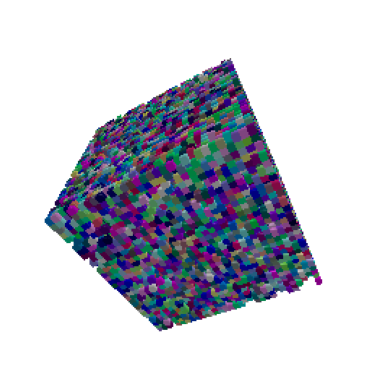

Sampling Steps:  29%|███████▏                 | 203/700 [00:42<04:48,  1.72it/s]

498 0.2817521393299103 0.9594871997833252
497 0.28317442536354065 0.9590684175491333


Sampling Steps:  29%|███████▎                 | 205/700 [00:42<02:55,  2.82it/s]

496 0.28460103273391724 0.9586460590362549
495 0.28603193163871765 0.9582200646400452


Sampling Steps:  30%|███████▍                 | 207/700 [00:42<02:00,  4.11it/s]

494 0.2874671518802643 0.9577904939651489
493 0.28890669345855713 0.9573572874069214


Sampling Steps:  30%|███████▍                 | 209/700 [00:43<01:32,  5.28it/s]

492 0.2903504967689514 0.9569203853607178
491 0.29179859161376953 0.9564797878265381


Sampling Steps:  30%|███████▌                 | 211/700 [00:43<01:19,  6.15it/s]

490 0.2932509183883667 0.9560354948043823
489 0.2947075366973877 0.9555875062942505


Sampling Steps:  30%|███████▌                 | 213/700 [00:43<01:12,  6.69it/s]

488 0.29616841673851013 0.955135703086853
487 0.297633558511734 0.9546802043914795


Sampling Steps:  31%|███████▋                 | 215/700 [00:43<01:09,  6.98it/s]

486 0.29910293221473694 0.9542208313941956
485 0.30057650804519653 0.9537577033042908


Sampling Steps:  31%|███████▊                 | 217/700 [00:44<01:07,  7.13it/s]

484 0.3020543158054352 0.9532907009124756
483 0.3035363554954529 0.9528198838233948


Sampling Steps:  31%|███████▊                 | 219/700 [00:44<01:06,  7.22it/s]

482 0.30502259731292725 0.9523451328277588
481 0.3065130114555359 0.9518664479255676


Sampling Steps:  32%|███████▉                 | 221/700 [00:44<01:05,  7.28it/s]

480 0.3080076277256012 0.9513838887214661
479 0.3095064163208008 0.9508973360061646


Sampling Steps:  32%|███████▉                 | 223/700 [00:45<01:05,  7.29it/s]

478 0.31100937724113464 0.9504068493843079
477 0.3125164806842804 0.9499123096466064


Sampling Steps:  32%|████████                 | 225/700 [00:45<01:05,  7.29it/s]

476 0.31402772665023804 0.9494137763977051
475 0.31554311513900757 0.9489112496376038


Sampling Steps:  32%|████████                 | 227/700 [00:45<01:04,  7.29it/s]

474 0.3170626163482666 0.9484046101570129
473 0.3185862600803375 0.9478939175605774


Sampling Steps:  33%|████████▏                | 229/700 [00:45<01:04,  7.30it/s]

472 0.32011398673057556 0.9473790526390076
471 0.3216457962989807 0.9468600749969482


Sampling Steps:  33%|████████▎                | 231/700 [00:46<01:04,  7.29it/s]

470 0.323181688785553 0.9463369250297546
469 0.32472166419029236 0.9458096623420715


Sampling Steps:  33%|████████▎                | 233/700 [00:46<01:04,  7.29it/s]

468 0.32626569271087646 0.9452781081199646
467 0.3278137743473053 0.9447423815727234


Sampling Steps:  34%|████████▍                | 235/700 [00:46<01:03,  7.30it/s]

466 0.32936587929725647 0.9442023634910583
465 0.33092200756073 0.9436581134796143


Sampling Steps:  34%|████████▍                | 237/700 [00:46<01:03,  7.31it/s]

464 0.33248212933540344 0.9431095719337463
463 0.33404627442359924 0.9425566792488098


Sampling Steps:  34%|████████▌                | 239/700 [00:47<01:03,  7.30it/s]

462 0.3356143832206726 0.9419994354248047
461 0.3371864855289459 0.9414379000663757


Sampling Steps:  34%|████████▌                | 241/700 [00:47<01:03,  7.22it/s]

460 0.3387625217437744 0.9408718943595886
459 0.3403424918651581 0.9403015375137329


Sampling Steps:  35%|████████▋                | 243/700 [00:47<01:02,  7.26it/s]

458 0.3419264256954193 0.939726710319519
457 0.34351426362991333 0.9391474723815918


Sampling Steps:  35%|████████▊                | 245/700 [00:48<01:02,  7.28it/s]

456 0.34510600566864014 0.9385637044906616
455 0.34670165181159973 0.9379754662513733


Sampling Steps:  35%|████████▊                | 247/700 [00:48<01:02,  7.26it/s]

454 0.3483011722564697 0.937382698059082
453 0.34990453720092773 0.9367853403091431


Sampling Steps:  36%|████████▉                | 249/700 [00:48<01:01,  7.28it/s]

452 0.35151174664497375 0.9361834526062012
451 0.3531228005886078 0.9355769753456116


Sampling Steps:  36%|████████▉                | 250/700 [00:48<01:01,  7.28it/s]

450 0.35473769903182983 0.9349658489227295
449 0.35635635256767273 0.9343501329421997
timestep: 449

Sample 0 distribution:
Histogram bins: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Histogram counts: [ 6364   228   399  1522 11048  6191   643   305   220  5848]
Percentiles: 10%: 0.000, 50%: 0.478, 90%: 1.000
RG range: [0.000, 1.000]
Alpha range: [0.000, 1.000]



ampling Steps:  36%|████████▉                | 250/700 [00:52<01:33,  4.81it/s]

KeyboardInterrupt: 

In [115]:
samples = inferencer.sample(
    prompt="blue sphere",
    num_samples=2,
    image_size=(32, 32, 32),
    show_intermediate=True,
    guidance_scale=1,
    use_mean_init=True,
    py3d=True
)

In [ ]:
inferencer.visualize_samples(samples, threshold=0.5)

In [ ]:
import torch
from pytorch3d.renderer import (
    FoVPerspectiveCameras, RasterizationSettings, MeshRenderer, MeshRasterizer, HardPhongShader
)
from pytorch3d.structures import Meshes
from pytorch3d.renderer.mesh.textures import TexturesVertex
from pytorch3d.io import save_obj
from pytorch3d.transforms import random_rotation
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
from pytorch3d.renderer import PointLights

device = "cuda"
# Voxel grid parameters
voxel_grid = samples[0, :, :, :, :]
print(voxel_grid.shape)

# Extract non-zero voxels
indices = torch.nonzero(voxel_grid[3, :, :, :], as_tuple=False)
vertices = indices.float()  # Convert voxel indices to vertices

cube_faces = torch.tensor([
    [0, 1, 2], [0, 2, 3],  # Bottom face
    [4, 5, 6], [4, 6, 7],  # Top face
    [0, 1, 5], [0, 5, 4],  # Side faces
    [2, 3, 7], [2, 7, 6],
    [1, 2, 6], [1, 6, 5],
    [0, 3, 7], [0, 7, 4]
], dtype=torch.int64, device=device)

# Generate vertices for each voxel cube
cube_vertices = torch.tensor([
    [0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],  # Bottom face
    [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]   # Top face
], dtype=torch.float32, device=device)

all_vertices = []
all_colors = []
all_faces = []

for idx, voxel in enumerate(indices):
    # Translate cube vertices to voxel position

    color = torch.stack([voxel_grid[0:3, voxel[0], voxel[1], voxel[2]]]*8)
    voxel_vertices = cube_vertices + voxel  # Add voxel position to cube vertices
    all_vertices.append(voxel_vertices)
    all_colors.append(color)

    # Offset cube faces by the current number of vertices
    offset = idx * 8  # 8 vertices per voxel
    all_faces.append(cube_faces + offset)

# Combine all vertices and faces
vertices = torch.cat(all_vertices, dim=0)
faces = torch.cat(all_faces, dim=0)
colors = torch.cat(all_colors, dim=0)

# Deduplicate vertices and remap faces
#unique_vertices, inverse_indices = torch.unique(vertices, dim=0, return_inverse=True)
#faces = inverse_indices[faces]
unique_vertices = vertices

# Debugging step
print(f"Number of vertices: {len(unique_vertices)}")
print(f"Max face index: {faces.max()}")
print(f"Number of faces: {faces.size(0)}")

# Ensure face indices are within bounds
assert faces.max() < len(unique_vertices), "Face indices exceed number of vertices!"

# Create the mesh object
mesh = Meshes(verts=[unique_vertices], faces=[faces])

# Define the object's center
object_center = unique_vertices.mean(dim=0)

# Generate a random camera position in spherical coordinates
radius = 60.0  # Distance from the object
theta = torch.rand(1) * 2 * torch.pi  # Azimuthal angle
phi =  torch.rand(1) * torch.pi  # Polar angle
#print(theta, phi)
theta, phi = torch.tensor([5.6699]), torch.tensor([1.5873])

# Convert spherical coordinates to Cartesian
camera_position = torch.tensor([
    radius * torch.sin(phi) * torch.cos(theta),
    radius * torch.sin(phi) * torch.sin(theta),
    radius * torch.cos(phi)
], device=device)

# Compute look-at rotation and translation
R, T = look_at_view_transform(eye=camera_position.unsqueeze(0), at=object_center.unsqueeze(0), up=((0, 1, 0),))

# Update the camera
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define a color for each vertex (e.g., all white or random colors)
vertex_colors = colors#torch.rand_like(unique_vertices)
# Alternatively, use random colors:
# vertex_colors = torch.rand_like(unique_vertices)

# Create vertex-based textures
textures = TexturesVertex(verts_features=[vertex_colors])

# Create the mesh object with textures
mesh = Meshes(verts=[unique_vertices], faces=[faces], textures=textures)

# Renderer settings (unchanged)
raster_settings = RasterizationSettings(image_size=256, blur_radius=0.0, faces_per_pixel=1)


lights = PointLights(device=device, location=[[0.0, 100.0, 100.0]])  # Place a light in front of the object
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)


# Render the image
images = renderer(mesh)
image = images[0, ..., :3].cpu().numpy()  # Get the RGB image

# Display the rendered image
plt.imshow(image)
plt.axis('off')
plt.show()